In [50]:
import sys
import subprocess
import os
import pandas as pd
import Bio
from Bio import SeqIO
import requests as r
from io import StringIO
import re
import matplotlib.pyplot as plt

In [ ]:
input_file = sys.argv[1]

In [4]:
input_file = "/storage/data1/marmi/annotation_project/crohn/coli1/annotation/V350171692_Run204_L02_121_bakta/V350171692_Run204_L02_121_extended.tsv"

In [5]:
pth = os.path.split(input_file)[0]

In [14]:
sample = pd.read_csv(input_file, sep = "\t", header = 0)

In [15]:
sample.fillna("", inplace=True)

In [26]:
sample_protein = input_file.rpartition('.')[0].replace("_extended", "") + ".faa"
sample_hprotein = input_file.rpartition('.')[0].replace("_extended", "") + ".hypotheticals.faa"

In [23]:
def parse_fasta(file_path):
    """
    Parses a FASTA file and returns a dictionary of sequences keyed by their headers.
    """
    seq_dict = {}
    for record in SeqIO.parse(file_path, "fasta"):
        seq_dict[record.id] = record
    return seq_dict

In [24]:
def write_fasta(sequences, output_path):
    """
    Writes a list of sequences to a FASTA file.
    """
    with open(output_path, "w") as output_handle:
        SeqIO.write(sequences, output_handle, "fasta")

In [18]:
sample = sample[sample["Entry UniProtKB"] != ""]

In [20]:
sample = sample[["Locus Tag","Entry UniProtKB"]]

In [21]:
sample.columns = ['old_id', 'new_id']
mapping_dict = pd.Series(sample.new_id.values, index=sample.old_id).to_dict()

In [39]:
fasta_sequences = SeqIO.parse(open(sample_protein), 'fasta')

updated_sequences = []

for seq_record in fasta_sequences:
    old_id = seq_record.id
    if old_id in mapping_dict:
        new_id = mapping_dict[old_id]
        seq_record.id = old_id + "|" +new_id
        seq_record.description = seq_record.description.replace(old_id, new_id)
        updated_sequences.append(seq_record)

fasta_sequences = SeqIO.parse(open(sample_hprotein), 'fasta')

for seq_record in fasta_sequences:
    old_id = seq_record.id
    if old_id in mapping_dict:
        new_id = mapping_dict[old_id]
        seq_record.id = old_id + "|" +new_id
        seq_record.description = seq_record.description.replace(old_id, new_id)
        updated_sequences.append(seq_record)

SeqIO.write(updated_sequences, sample_protein.rpartition('.')[0]+".to_validate.faa", 'fasta')

4726

In [37]:
with open(input_file.rpartition('.')[0].replace("_extended","")+".ids.csv", "w") as f:
    f.write(",".join(sample['new_id'].values.tolist()))

In [44]:
# updated_sequences = []
# for i in range(len(sample['new_id'])):
#     cID=sample['new_id'].iloc[i]
#     baseUrl="http://www.uniprot.org/uniprot/"
#     currentUrl=baseUrl+cID+".fasta"
#     response = r.post(currentUrl)
#     cData=''.join(response.text)
#     Seq=StringIO(cData)
#     pSeq=list(SeqIO.parse(Seq,'fasta'))
#     updated_sequences.append(pSeq)

# SeqIO.write(updated_sequences, sample_protein.rpartition('.')[0]+".uniprot.faa", 'fasta')

In [46]:
result_anno = subprocess.run(['upimapi', '-i', input_file.rpartition('.')[0].replace("_extended","")+".ids.csv", \
                                         '-o', os.path.split(input_file)[0]+"/kb", \
                                         '--fasta', \
                                         '-db', 'uniprot'], \
                                       check = True)

2024-07-25 16:16:33: ID mapping has begun.
Auto determined "full id" as: False


Getting valid UniProt IDs: 100%|==========| 1/1 [00:08<00:00,  8.88s/it]


2024-07-25 16:16:42: 4720 UniProt IDs identified as valid.
/storage/data1/marmi/annotation_project/crohn/coli1/annotation/V350171692_Run204_L02_121_bakta/kb/uniprotinfo.fasta not found. Will perform mapping for all IDs.
Information already gathered for 0 ids. Still missing for 4719.


Building FASTA from 8 IDs.:   0%|          | 0/1 [00:00<?, ?it/s]

Information already gathered for 2355 ids. Still missing for 8.


Building FASTA from 8 IDs.:   0%|          | 0/1 [00:00<?, ?it/s]

Information already gathered for 2355 ids. Still missing for 8.


Building FASTA from 8 IDs.:   0%|          | 0/1 [00:00<?, ?it/s]

Information already gathered for 2355 ids. Still missing for 8.


Building FASTA from 8 IDs.:   0%|          | 0/1 [00:00<?, ?it/s]

Information already gathered for 2355 ids. Still missing for 8.
Maximum iterations were made. Results related to 8 IDs were not obtained. IDs with missing information are available at /storage/data1/marmi/annotation_project/crohn/coli1/annotation/V350171692_Run204_L02_121_bakta/kb/ids_unmapped.txt and information obtained is available at /storage/data1/marmi/annotation_project/crohn/coli1/annotation/V350171692_Run204_L02_121_bakta/kb/uniprotinfo.fasta
2024-07-25 16:17:14: UPIMAPI analysis finished in 00h00m41s


Building FASTA from 8 IDs.: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it]


In [ ]:
result_makedb = subprocess.run(['makeblastdb', '-in', os.path.split(input_file)[0]+"/kb/uniprotinfo.fasta", \
                                         '-out', os.path.split(input_file)[0]+"/kb/db", \
                                         '-dbtype', 'prot'], \
                                check = True)

In [ ]:
result_blast = subprocess.run(['blastp', '-query', sample_protein.rpartition('.')[0]+".to_validate.faa", \
                                         '-db', os.path.split(input_file)[0]+"/kb/db", \
                                         '-out', sample_protein.rpartition('.')[0]+".blast", \
                                         '-outfmt', '6'], \
                                check = True)

In [48]:

# Define the input and output file paths
blast_file = sample_protein.rpartition('.')[0]+".blast"
output_file_blast = sample_protein.rpartition('.')[0]+".filtered.blast"

# Function to extract the ID after the first `|` from the query and subject
def extract_ids(query_id, subject_id):
    query_match = re.search(r'\|([^|]+)', query_id)
    subject_match = re.search(r'\|([^|]+)\|', subject_id)
    if query_match and subject_match:
        return query_match.group(1), subject_match.group(1)
    return None, None

# Open the input and output files
with open(blast_file, 'r') as infile, open(output_file_blast, 'w') as outfile:
    for line in infile:
        columns = line.strip().split()
        if len(columns) < 3:
            continue
        query_id = columns[0]
        subject_id = columns[1]
        query_extract, subject_extract = extract_ids(query_id, subject_id)
        if query_extract and query_extract == subject_extract:
            outfile.write(line)

print(f"Filtered results written to {output_file_blast}")


Filtered results written to /storage/data1/marmi/annotation_project/crohn/coli1/annotation/V350171692_Run204_L02_121_bakta/filtered_results.out


In [49]:
blast = pd.read_csv(output_file_blast, sep="\t", header = None)

In [61]:
blast = blast.drop_duplicates(subset=0, keep='first')

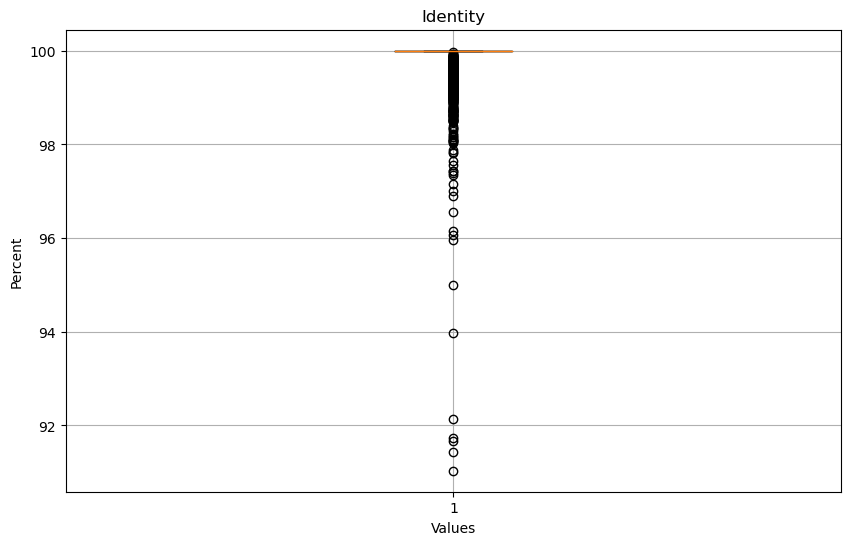

In [64]:
Identity = blast.iloc[:, 2]

# Plot the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(Identity)
plt.title('Identity')
plt.ylabel('Percent')
plt.xlabel('Values')
plt.grid(True)
plt.show()